In [ ]:
# import necessary libraries
import json
import numpy as np
import datetime
import arcpy
import os
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
from statsmodels.robust.robust_linear_model import RLM
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import MultipleLocator
from scipy.stats import pearsonr,spearmanr

## Preparation

In [ ]:
# Configure ArcPy environment and define input data paths
arcpy.env.overwriteOutput = True

VS_shp_path = 'Globe_valid_VS.shp'# created in ArcGIS
VS_buffer_path = 'Global_valid_VS_buffer50.shp'# created in ArcGIS, buffer 50 m
VS_info_path='Result datasets/Global water level datasets (processed)/S3_globe_water_level_dataset2.json'
SWORD_folder='Your SWORD shapefile folder'

GRDC_st_shp_path = 'Result datasets/Validation dataset/discharge_gauge_shp/globe_gauge_discharge_data_8y.shp'
GRDC_st_buffer_path = 'Result datasets/Validation dataset/discharge_gauge_shp/globe_gauge_discharge_data_8y_buffer500.shp'
GRDC_info_path = 'Result datasets/Validation dataset/globe_gauge_discharge_data_8y.json'

In [ ]:
# Collect all SWORD river network shapefile paths
# Recursively searches the SWORD directory to locate all reach shapefiles:
sword_files=[]
for root, dirs, files in os.walk(SWORD_folder):
    for file in files:
        if ('reaches' in file) & (file.endswith('.shp')):
            full_path=os.path.join(root, file)
            sword_files.append(full_path)

print(f"Found {len(sword_files)} SWORD river network files")
sword_files

找到 60 个SWORD河网文件


['D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AF\\af_sword_reaches_hb11_v17b.shp',
 'D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AF\\af_sword_reaches_hb12_v17b.shp',
 'D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AF\\af_sword_reaches_hb13_v17b.shp',
 'D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AF\\af_sword_reaches_hb14_v17b.shp',
 'D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AF\\af_sword_reaches_hb15_v17b.shp',
 'D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AF\\af_sword_reaches_hb16_v17b.shp',
 'D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AF\\af_sword_reaches_hb17_v17b.shp',
 'D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AF\\af_sword_reaches_hb18_v17b.shp',
 'D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AS\\as_sword_reaches_hb31_v17b.shp',
 'D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AS\\as_sword_reaches_hb32_v17b.shp',
 'D:\\Geography dataset\\SWORD\\SWORD_v17b_shp\\shp\\AS\\as_sword_reaches_hb33_v17b.shp',
 'D:\\Geog

In [ ]:
# Import our global altimetric RWL dataset
with open(VS_info_path, 'r') as f:
    VS_info = json.load(f)

len(VS_info)

46993

In [ ]:
# Import global discharge gauge dataset
with open(GRDC_info_path, 'r') as f:
    gauge_info = json.load(f)

len(gauge_info)

11617

## Match gauging stations with VSs according to their promixity

In [ ]:
'''
Process SWORD files and build river network database
Creates a comprehensive reach connectivity database from all SWORD shapefiles:
- Iterates through all SWORD reach files
- Extracts upstream and downstream reach relationships
- Builds network dictionary structure for topology analysis
'''
reach_network = {}# {reach_id: {'up': [up_ids], 'down': [down_ids]}}

for i, sword_file in enumerate(sword_files):
    print(f"Processing SWORD file {i+1}/{len(sword_files)}: {os.path.basename(sword_file)}")
    
    # Check SWORD file coordinate system
    sword_sr = arcpy.Describe(sword_file).spatialReference
    print(f"  SWORD file coordinate system: {sword_sr.name} ({sword_sr.factoryCode})")

    print("  Reading river network relationships...")
    with arcpy.da.SearchCursor(sword_file, ['reach_id', 'rch_id_up', 'rch_id_dn']) as cursor:
        for row in cursor:
            reach_id, up_id, down_id = row
            
            # Process upstream IDs
            up_ids = []
            if up_id is not None and str(up_id).strip():
                up_ids = [int(item) for item in str(up_id).strip().split()]
                
            # Process downstream IDs
            down_ids = []
            if down_id is not None and str(down_id).strip():
                down_ids = [int(item) for item in str(down_id).strip().split()]
            
            # Store network relationships
            reach_network[int(reach_id)] = {
                'up': up_ids,
                'down': down_ids
            }


处理SWORD文件 1/60: af_sword_reaches_hb11_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
  读取河网关系...
处理SWORD文件 2/60: af_sword_reaches_hb12_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
  读取河网关系...
处理SWORD文件 3/60: af_sword_reaches_hb13_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
  读取河网关系...
处理SWORD文件 4/60: af_sword_reaches_hb14_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
  读取河网关系...
处理SWORD文件 5/60: af_sword_reaches_hb15_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
  读取河网关系...
处理SWORD文件 6/60: af_sword_reaches_hb16_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
  读取河网关系...
处理SWORD文件 7/60: af_sword_reaches_hb17_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
  读取河网关系...
处理SWORD文件 8/60: af_sword_reaches_hb18_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
  读取河网关系...
处理SWORD文件 9/60: as_sword_reaches_hb31_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
  读取河网关系...
处理SWORD文件 10/60: as_sword_reaches_hb32_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
  读取河网关系...
处理SWORD文件 11/60: as_sword_reaches_hb33_v17b.shp
  SWORD文件坐标系: GCS_WGS

In [ ]:
# Display river network database statistics
# Reports the total number of reaches processed and stored in the network dictionary
print(len(reach_network))
print(len(reach_network.keys()))


248673
248673


In [ ]:
# Define function to retrieve connected upstream or downstream reaches
# Recursively traverses river network to find continuous reach sequences:
# - Follows upstream/downstream connections from a starting reach
# - Excludes specified reaches and automatically stops at reservoirs/lakes
# - Limits search to maximum count with cycle detection
def get_connected_reaches(reach_network, start_reach_id, direction='upstream', max_count=3, 
                          exclude_reaches=None, result = [], search_reach=0):
    """
    Retrieve continuous upstream or downstream reaches for a given reach, excluding specified reaches; 
    automatically terminates when encountering reservoirs or lakes
    
    Parameters:
    reach_network -- Dictionary containing all reach information {reach_id: {'up': [up_ids], 'down': [down_ids]}}
    start_reach_id -- Starting reach ID
    direction -- 'upstream' for upstream reaches, 'downstream' for downstream reaches
    max_count -- Maximum number of retrieve count
    exclude_reaches -- List of reach IDs to exclude
    
    Returns:
    List of continuous reach IDs
    """

    if exclude_reaches is None:
        exclude_reaches = set()
    else:
        exclude_reaches = set(exclude_reaches)  # Convert to set for improved lookup efficiency
        
    current_id = start_reach_id
    
    # Determine field name to use (upstream or downstream) and corresponding direction
    field = 'up' if direction == 'upstream' else 'down'
    
    if search_reach < max_count:
        # Check if current ID exists in network
        if current_id not in reach_network:
            return result

        if (current_id % 10 == 3) | (current_id % 10 == 4):
            return result
            
        result.append(current_id)
        search_reach += 1
        # Get next ID (take first upstream/downstream ID)
        next_ids = reach_network[current_id][field]
        if not next_ids:
            return result
            
        for next_id in next_ids:  # Recursive call
        # Check if ID is valid and not in exclusion list
            if next_id is None or next_id in exclude_reaches:
                continue
            # Avoid cycles
            if next_id in result:
                continue
            
            get_connected_reaches(reach_network, next_id, direction, max_count, 
                          exclude_reaches, result, search_reach)
    else:
        #print(result)
        return result


In [ ]:
# Match virtual stations with streamflow gauges through river network analysis
# Processes SWORD files to find spatial intersections between virtual stations and GRDC stations:
# - Loads GRDC station buffer data and extracts coordinate system information
# - Iterates through SWORD files to find VS-river intersections
# - For each intersection, searches for nearby GRDC stations within 30km buffer
# - Traces upstream/downstream connected reaches and identifies GRDC matches
# - Builds comprehensive matching database with station metadata
grdc_gdf = gpd.read_file(GRDC_st_buffer_path)
print('Gauging station coordinate system: ',grdc_gdf.crs)

matched_VS_info = []
VS_nodeids = np.array([int(item['nodeid']) for item in VS_info])
GRDC_ids = np.array([item['id'] for item in gauge_info])#string

for i, sword_file in enumerate(sword_files):
   print(f"Processing SWORD file {i+1}/{len(sword_files)}: {os.path.basename(sword_file)}")
   
   # Check SWORD file coordinate system
   sword_sr = arcpy.Describe(sword_file).spatialReference
   print(f"  SWORD file coordinate system: {sword_sr.name} ({sword_sr.factoryCode})")
   print('   Starting river network and virtual station intersection analysis')

   temp_intersect = f'in_memory/intersect_{i}'
   arcpy.analysis.Intersect([VS_buffer_path, sword_file], temp_intersect)
   intersect_count = int(arcpy.GetCount_management(temp_intersect).getOutput(0))
   print(f'  Found {intersect_count} intersection pairs')

   fields = ['nodeid', 'reach_id']
   matched_count = 0
   if intersect_count>0:
       with arcpy.da.SearchCursor(temp_intersect, fields) as cursor:
           for row in cursor:
               VS_id = int(row[0])
               sword_reachid = int(row[1])
               
               VS_idx = np.where(VS_nodeids == VS_id)[0][0]
               selected_VS_info = VS_info[VS_idx]

               vs_point = Point(selected_VS_info['center_lon'], selected_VS_info['center_lat'])
               vs_gdf = gpd.GeoDataFrame([1], geometry=[vs_point], crs='EPSG:4326')#Latitude/longitude
               vs_gdf_proj = vs_gdf.to_crs('EPSG:3857')  # Web Mercator
               vs_buffer = vs_gdf_proj.geometry.buffer(40000)  # 35km
               vs_buffer_gdf = gpd.GeoDataFrame([1], geometry=vs_buffer, crs='EPSG:3857')
               vs_buffer_gdf = vs_buffer_gdf.to_crs('EPSG:4326')#Latitude/longitude
               intersects = gpd.overlay(vs_buffer_gdf, grdc_gdf, how='intersection')
               # Skip if no GRDC stations within 40km range
               if len(intersects) == 0:
                   print(f"    VS_ID {VS_id} has no nearby gauge stations, skipping")
                   continue

               result = []
               get_connected_reaches(reach_network, sword_reachid, direction='upstream', max_count=3, 
                         exclude_reaches=None, result=result, search_reach=0)
               get_connected_reaches(reach_network, sword_reachid, direction='downstream', max_count=3, 
                         exclude_reaches=None, result=result, search_reach=0)
               
               result = np.unique(result)
               if len(result)>0:
                   print(f"    VS_ID {VS_id} found {len(result)} connected reaches")
                   
                   result_str = ','.join(map(str, result))
                   where_clause = f'reach_id In ({result_str})'
                   temp_sword_selected = f"in_memory/sword_selected_{i}_{VS_id}"
                   arcpy.management.MakeFeatureLayer(sword_file, temp_sword_selected, where_clause)
                   selected_count = int(arcpy.GetCount_management(temp_sword_selected).getOutput(0))
                   print(f"    Selected {selected_count} reaches")

                   if selected_count>0:
                       temp_grdc_intersect = f"in_memory/grdc_intersect_{i}_{VS_id}"
                       arcpy.analysis.Intersect([temp_sword_selected, GRDC_st_buffer_path], temp_grdc_intersect)
                       grdc_intersect_count = int(arcpy.GetCount_management(temp_grdc_intersect).getOutput(0))
                       print(f"    Found {grdc_intersect_count} GRDC station intersections")

                       if grdc_intersect_count>0:
                           grdc_fields = ['reach_id', 'id']
                           with arcpy.da.SearchCursor(temp_grdc_intersect, grdc_fields) as grdc_cursor:
                               for grdc_row in grdc_cursor:
                                   grdc_no = grdc_row[1]#GRDC station ID
                                   grdc_reach_id = int(grdc_row[0])

                                   grdc_st_idx = np.where((GRDC_ids == grdc_no) | (GRDC_ids == str(grdc_no)))[0][0]
                                   grdc_st_info = gauge_info[grdc_st_idx]
                                   selected_VS_info['gauge_id'] = grdc_no
                                   selected_VS_info['gauge_reachid'] = grdc_reach_id
                                   selected_VS_info['VS_reachid_v17'] = sword_reachid
                                   selected_VS_info['gauge_time'] = grdc_st_info['time']
                                   selected_VS_info['gauge_discharge'] = grdc_st_info['discharge']
                                   selected_VS_info['gauge_agency'] = grdc_st_info['agency']

                                   matched_VS_info.append(selected_VS_info)
                                   matched_count += 1

                       if arcpy.Exists(temp_grdc_intersect):
                           arcpy.Delete_management(temp_grdc_intersect)
                   if arcpy.Exists(temp_sword_selected):
                       arcpy.Delete_management(temp_sword_selected)
   if arcpy.Exists(temp_intersect):
       arcpy.Delete_management(temp_intersect)

   print(f"  Completed processing SWORD file {os.path.basename(sword_file)}, matched {matched_count} VS-GRDC pairs")

print(f"Total found {len(matched_VS_info)} VS-GRDC matching pairs")


d:\Arcgispro\install\bin\Python\envs\arcgispro-py3\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files.  Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


实测站坐标系:  EPSG:4326
处理SWORD文件 1/60: af_sword_reaches_hb11_v17b.shp
  SWORD文件坐标系: GCS_WGS_1984 (4326)
   开始判断河网与测高虚拟站相交情况
  发现193个相交配对
    VS_ID 11430000010671 周围没有实测站，跳过
    VS_ID 11430000010771 周围没有实测站，跳过
    VS_ID 11430000010871 周围没有实测站，跳过
    VS_ID 11430000010341 周围没有实测站，跳过
    VS_ID 11441100010111 周围没有实测站，跳过
    VS_ID 11441100010211 周围没有实测站，跳过
    VS_ID 11441100010311 周围没有实测站，跳过
    VS_ID 11441100160051 周围没有实测站，跳过
    VS_ID 11441100240221 周围没有实测站，跳过
    VS_ID 11441100240751 周围没有实测站，跳过
    VS_ID 11441100240851 周围没有实测站，跳过
    VS_ID 11441100250471 周围没有实测站，跳过
    VS_ID 11441100260821 周围没有实测站，跳过
    VS_ID 11441100260791 周围没有实测站，跳过
    VS_ID 11441100290491 周围没有实测站，跳过
    VS_ID 11441100300091 周围没有实测站，跳过
    VS_ID 11441100310231 周围没有实测站，跳过
    VS_ID 11441100330321 周围没有实测站，跳过
    VS_ID 11441100360211 周围没有实测站，跳过
    VS_ID 11441100360601 周围没有实测站，跳过
    VS_ID 11441100370971 周围没有实测站，跳过
    VS_ID 11441100380211 周围没有实测站，跳过
    VS_ID 11441100390551 周围没有实测站，跳过
    VS_ID 11441100400051 周围没有实测站，跳过
   

In [ ]:
# Save matched VS-GRDC pairs to JSON file
# Exports the complete matching database to persistent storage:
# - Saves all matched virtual station and GRDC gauge information
# - Uses UTF-8 encoding to preserve special characters
# - Stores results in JSON format for easy data exchange
save_path = 'Your save path'

with open(save_path, 'w', encoding='utf-8') as f:
   json.dump(matched_VS_info, f, ensure_ascii=False)

print('Matching results saved')


匹配结果已保存


In [ ]:
# Load
save_path = 'Result datasets/Validation dataset/Matched_gaugeQ_and_VS.json'

with open(save_path, 'r') as f:
	matched_VS_info = json.load(f)

len(matched_VS_info)

4563

## Validating VS WSEs against gauge discharge

In [ ]:
# Process validation dataset and calculate comparison metrics
# Creates comprehensive validation statistics for VS-gauge station pairs:
# - Merges virtual station water surface elevation with gauge discharge data
# - Calculates correlation coefficients, fluctuations, and change rates
# - Applies robust linear regression to quantify temporal trends
# - Filters results based on data quality criteria (>=5 points, fluctuation <30 m)
validate_dataset = []

for idx, item in enumerate(matched_VS_info):
   VS_time = np.array(item['monitor_time'])
   VS_wse = np.array(item['monitor_wse'])
   VS_fluctuation = item['fluctuation2']

   gauge_time = np.array(item['gauge_time'])
   gauge_discharge = np.array(item['gauge_discharge'])

   VS_df = pd.DataFrame({
       't': pd.to_datetime(np.int64(VS_time), origin='1899-12-30', unit='D'),
       'h': VS_wse,
   })
   VS_df.set_index('t', inplace=True)
   VS_df = VS_df.dropna()

   gauge_df = pd.DataFrame({
       't': pd.to_datetime(gauge_time),
       'Q': gauge_discharge,
   })
   gauge_df.set_index('t', inplace=True)
   gauge_df = gauge_df.dropna()

   validate_df = pd.merge(VS_df, gauge_df, 
                          left_index=True, right_index=True,
                          how='inner')
   if (len(validate_df) >= 5) & (VS_fluctuation < 30):
       CC = validate_df['h'].corr(validate_df['Q'])
       item['validate_CC'] = CC
       item['validate_time'] = validate_df.index.strftime('%Y-%m-%d').tolist()
       item['validate_VS_wse'] = validate_df['h'].tolist()
       item['validate_gauge_Q'] = validate_df['Q'].tolist()

       item['validate_VS_fluctuation'] = VS_fluctuation
       item['validate_gauge_fluctuation_abs'] = validate_df['Q'].max() - validate_df['Q'].min()
       item['validate_gauge_fluctuation_rel'] = (validate_df['Q'].max() - validate_df['Q'].min())/validate_df['Q'].mean()*100
       
       matched_start_day, matched_end_day = validate_df.index[0], validate_df.index[-1]
       t0 = matched_start_day
       time_days = (validate_df.index-t0).days.astype(float)
       temp_df = pd.DataFrame({'t': time_days, 'h': validate_df['h'], 'Q': validate_df['Q']})

       X = sm.add_constant(temp_df['t'])
       model=RLM(temp_df['h'], X, M=sm.robust.norms.TukeyBiweight())
       results=model.fit()
       item['validate_VS_changerate'] = results.params['t']*365*100 #cm/yr
       item['validate_VS_pvalue'] = results.pvalues['t']

       X = sm.add_constant(temp_df['t'])
       model=RLM(temp_df['Q'], X, M=sm.robust.norms.TukeyBiweight())
       results=model.fit()
       item['validate_gauge_changerate'] = results.params['t']*365*1000 #dm^3/s/yr
       item['validate_gauge_pvalue'] = results.pvalues['t']

       adjusted_gauge_df = gauge_df[(gauge_df.index>=matched_start_day) & (gauge_df.index<=matched_end_day)]
       time_days = (adjusted_gauge_df.index - adjusted_gauge_df.index[0]).days.astype(float)
       temp_df = pd.DataFrame({'t': time_days, 'Q': adjusted_gauge_df['Q']})

       X = sm.add_constant(temp_df['t'])
       model=RLM(temp_df['Q'], X, M=sm.robust.norms.TukeyBiweight())
       results=model.fit()
       item['whole_gauge_changerate'] = results.params['t']*365*1000 #dm^3/s/yr
       item['whole_gauge_pvalue'] = results.pvalues['t']

       item['whole_gauge_fluctuation_abs'] = adjusted_gauge_df['Q'].max() - adjusted_gauge_df['Q'].min()
       item['whole_gauge_fluctuation_rel'] = (adjusted_gauge_df['Q'].max() - adjusted_gauge_df['Q'].min())/validate_df['Q'].mean()*100

       validate_dataset.append(item)

   if idx%500 == 0:
       print(f'{idx+1}/{len(matched_VS_info)}')

# Filter validation dataset to include only records with valid correlation coefficients
# Removes any incomplete validation records from the final dataset
validate_dataset2 = [item for item in validate_dataset if item['validate_CC']]
len(validate_dataset2)


1/4563
501/4563
1001/4563
1501/4563
2001/4563
2501/4563
3001/4563


d:\Arcgispro\install\bin\Python\envs\arcgispro-py3\Lib\site-packages\statsmodels\robust\robust_linear_model.py:166: RuntimeWarning: divide by zero encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
d:\Arcgispro\install\bin\Python\envs\arcgispro-py3\Lib\site-packages\statsmodels\robust\robust_linear_model.py:166: RuntimeWarning: invalid value encountered in divide
  return self.M(tmp_resid / tmp_results.scale).sum()
d:\Arcgispro\install\bin\Python\envs\arcgispro-py3\Lib\site-packages\statsmodels\robust\norms.py:817: RuntimeWarning: invalid value encountered in multiply
  return -(1 - (z / self.c)**2)**3 * subset * factor + factor


3501/4563
4001/4563
4501/4563


4418

In [ ]:
# Extract geographical and validation statistics from filtered dataset
# Compiles coordinate information and correlation coefficients:
# - Extracts longitude/latitude coordinates for spatial analysis
# - Collects reach IDs and correlation coefficients for performance assessment
# - Calculates summary statistics (median and mean correlation) for validation results
lons = [item['center_lon'] for item in validate_dataset2]
lats = [item['center_lat'] for item in validate_dataset2]
reachids = np.array([item['VS_reachid_v17'] for item in validate_dataset2])

CCs = [item['validate_CC'] for item in validate_dataset2]
print(f'Median CC: {np.median(CCs):.2f}\nMean CC: {np.mean(CCs):.2f}')


Median CC: 0.67
Mean CC: 0.58


d:\Arcgispro\install\bin\Python\envs\arcgispro-py3\Lib\site-packages\cartopy\mpl\feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


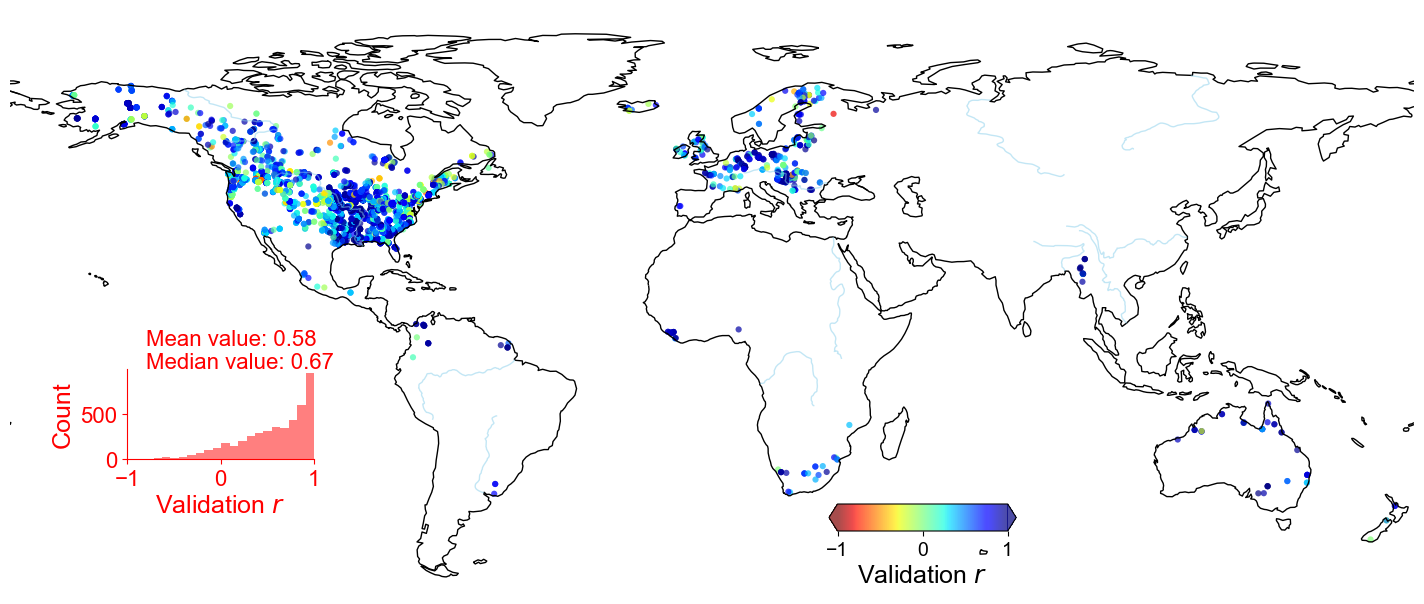

In [ ]:
# Create global validation visualization with correlation analysis
# Generates comprehensive map-based visualization of VS-GRDC validation results:
# - Displays global distribution of validation points with correlation color coding
# - Includes histogram subplot showing correlation coefficient distribution
# - Adds statistical summary (mean/median) and colorbar for interpretation
# - Uses cartopy for geographic projection and matplotlib for styling
from matplotlib import rcParams
rcParams['font.family'] = 'Arial'
rcParams['pdf.fonttype']=42
rcParams['ps.fonttype']=42

lon_min=-180
lon_max=180
lat_min=-60
lat_max=90

fig=plt.figure(figsize=(23.4,9))

rect1=[0.05,0.25,0.6,0.65]
ax1=fig.add_axes(rect=rect1, projection=ccrs.PlateCarree())
ax1.coastlines()
ax1.set_global()
ax1.set_extent([lon_min,lon_max,lat_min,lat_max],crs=ccrs.PlateCarree())
sizes=20
colors=CCs
ax1.add_feature(cfeature.RIVERS, color='skyblue', alpha=0.5)
scatter=ax1.scatter(lons,lats, sizes,colors,cmap='jet_r', alpha=0.7, 
                   edgecolors='none', linewidths=0.5, transform=ccrs.PlateCarree(),
                  vmax=1, vmin=-1)
for spine in ax1.spines.values():
   spine.set_visible(False)

rect4=[0.4,0.32,0.08,0.03]
ax4=fig.add_axes(rect=rect4)
cbar=plt.colorbar(scatter,cax=ax4, shrink=0.7,orientation="horizontal",extend="both")
cbar.set_label('Validation $r$',fontsize=18,fontname='Arial')
cbar.ax.tick_params(labelsize=14)

rect9=[0.1,0.4,0.08,0.1]
ax9=fig.add_axes(rect=rect9)
ax9.hist(CCs, bins=20, edgecolor='none', color='red', alpha=0.5)
ax9.set_ylabel('Count', fontname='Arial',fontsize=18,color='red')
ax9.set_xlabel('Validation $r$', fontname='Arial',fontsize=18,color='red')
ax9.tick_params(labelsize=16,colors='red')
mean_value=np.mean(CCs)
median_value=np.median(CCs)
ax9.text(-0.8, 1000, f'Mean value: {mean_value:.2f}\nMedian value: {median_value:.2f}', fontname='Arial', color='red', fontsize=16)
ax9.spines['right'].set_visible(False)
ax9.spines['top'].set_visible(False)
ax9.spines['left'].set_color('red')
ax9.spines['bottom'].set_color('red')
ax9.set_xlim([-1,1])
ax9.set_facecolor('none')

plt.show()

In [ ]:
# ave figure
ouput_name='validate_HandQ.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax1,))

meta NOT subset; don't know how to subset; dropped


## Validating VS WSE changes against gauge results

In [ ]:
# Extract change rate and fluctuation metrics for comparative analysis
# Compiles temporal trend and variability statistics from validation dataset:
# - VS change rates in water surface elevation (cm/yr)
# - Gauge discharge change rates during validation period (m³/s/yr)
# - Whole gauge period discharge change rates for broader context
# - Fluctuation metrics comparing VS water levels with gauge discharge variability

VS_changerate = [item['validate_VS_changerate'] for item in validate_dataset2]#cm/yr
gauge_changerate = [item['validate_gauge_changerate']/1000 for item in validate_dataset2]#m3/s/yr
whole_changerate = [item['whole_gauge_changerate']/1000 for item in validate_dataset2]#m3/s/yr

VS_fluctuation = [item['validate_VS_fluctuation'] for item in validate_dataset2]#m
gauge_fluctuation = [item['validate_gauge_fluctuation_rel'] for item in validate_dataset2]#%
whole_gauge_fluctuation = [item['whole_gauge_fluctuation_rel'] for item in validate_dataset2]#%


### Compare with in-situ changes from daily continous records and those sampled at days with altimetry obs.

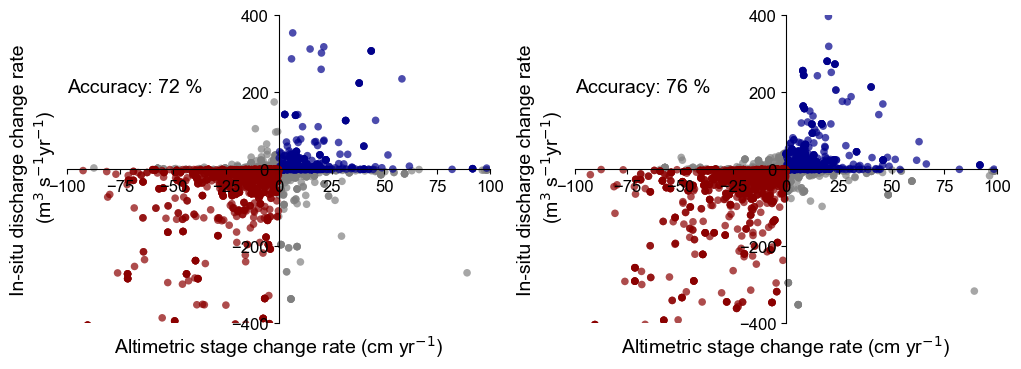

In [ ]:
# Create comparative analysis plots for change rate validation
# Generates dual scatter plots comparing altimetric stage vs discharge change rates:
# - Left plot: VS change rates vs in-situ discharge trends from daily records
# - Right plot: VS change rates vs in-situ discharge trends from periods with altimetry obs.
# - Color codes points by quadrant to assess directional agreement
# - Calculates accuracy metrics based on consistent trend directions
def stats_cal(slope,intercept,gauge_changerate,VS_changerate):
   # Calculate R² and RMSE
   predicted = slope * gauge_changerate + intercept
   residuals = VS_changerate - predicted
   ss_res = np.sum(residuals**2)
   ss_tot = np.sum((VS_changerate - np.mean(VS_changerate))**2)
   r2 = 1 - (ss_res / ss_tot)
   rmse = np.sqrt(np.mean(residuals**2))
   CC, _ = spearmanr(VS_changerate, gauge_changerate)
   bias=np.sum(residuals)/len(gauge_changerate)
   return r2,CC,bias

fig=plt.figure(figsize=(12,4))#23.5,18

ax1 = fig.add_subplot(1, 2, 1)  # First subplot
ax2 = fig.add_subplot(1, 2, 2)  # Second subplot
'''
scatter = ax1.scatter(VS_fluctuation, whole_gauge_fluctuation, c='gray', s=40, edgecolor='none', cmap='jet',alpha=0.7)
ax1.set_xlabel('Altimetric stage fluctuation (m)',fontsize=14)
ax1.set_ylabel('In-situ discharge fluctuation (%)',fontsize=14)
ax1.tick_params(labelsize=12)

model=RLM(whole_gauge_fluctuation,sm.add_constant(VS_fluctuation),M=sm.robust.norms.TukeyBiweight())
results=model.fit()
slope= results.params[1]
intercept= results.params[0]
# Add fitting line
ax1.plot([-100, 100],[-100*slope+intercept, 100*slope+intercept],'r--')
text = f'$y$ = {slope:.2f}$x$ + {abs(intercept):.2f}'
ax1.text(10, 8, text, fontsize=14, color='red',fontname='Arial')
ax1.set_xlim([0,30])
ax1.set_ylim([0,10000])
r2,CC,bias=stats_cal(slope,intercept,np.array(VS_fluctuation),np.array(whole_gauge_fluctuation))
stats_text = f'$R^2$ = {r2:.2f}\nBias = {bias:.2f}'#\nRMSE = {rmse:.0f}
ax1.text(15, 2, stats_text, fontsize=14, color='blue', fontname='Arial')
ax1.yaxis.set_major_locator(MultipleLocator(2000))
ax1.xaxis.set_major_locator(MultipleLocator(10))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
'''
# Daily scale change rate
first_quadrant = (np.array(VS_changerate) > 0) & (np.array(whole_changerate) > 0)
third_quadrant = (np.array(VS_changerate) < 0) & (np.array(whole_changerate) < 0)
other_quadrants = ~(first_quadrant | third_quadrant)

ax1.scatter(
   np.array(VS_changerate)[other_quadrants], 
   np.array(whole_changerate)[other_quadrants], 
   color='gray', 
   s=30, 
   edgecolor='none', 
   alpha=0.7
)
ax1.scatter(
   np.array(VS_changerate)[first_quadrant], 
   np.array(whole_changerate)[first_quadrant], 
   color='darkblue', 
   s=30, 
   edgecolor='none', 
   alpha=0.7,
)
ax1.scatter(
   np.array(VS_changerate)[third_quadrant], 
   np.array(whole_changerate)[third_quadrant], 
   color='darkred', 
   s=30, 
   edgecolor='none', 
   alpha=0.7,
)

ax1.set_xlabel('Altimetric stage change rate (cm yr$^{-1}$)',fontsize=14, labelpad=100)
ax1.set_ylabel('In-situ discharge change rate\n (m$^3$ s$^{-1}$yr$^{-1}$)',fontsize=14, labelpad=125)
ax1.tick_params(labelsize=12)

model=RLM(whole_changerate,sm.add_constant(VS_changerate),M=sm.robust.norms.TukeyBiweight())
results=model.fit()
slope= results.params[1]
intercept= results.params[0]
# Add fitting line
#ax1.plot([-100, 100],[-100, 100],color='k',linestyle='--',linewidth=1.5)
#ax1.plot([-100, 100],[-100*slope+intercept, 100*slope+intercept],'r--')
#text = f'$y$ = {slope:.2f}$x$ + {abs(intercept):.2f}'
#ax1.text(20, -10, text, fontsize=14, color='red',fontname='Arial')
ration = (sum(first_quadrant)+sum(third_quadrant))/len(first_quadrant)*100
ratio_text = f"Accuracy: {ration:.0f} %"
ax1.text(-100, 200, ratio_text, fontsize=14, color='black', fontname='Arial')

ax1.set_xlim([-100,100])
ax1.set_ylim([-400,400])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_position(('data', 0))  # x-axis to y=0
ax1.spines['left'].set_position(('data', 0))    # y-axis to x=0
ax1.yaxis.set_major_locator(MultipleLocator(200))

# Altimetry sample change rate
first_quadrant = (np.array(VS_changerate) > 0) & (np.array(gauge_changerate) > 0)
third_quadrant = (np.array(VS_changerate) < 0) & (np.array(gauge_changerate) < 0)
other_quadrants = ~(first_quadrant | third_quadrant)

ax2.scatter(
   np.array(VS_changerate)[other_quadrants], 
   np.array(gauge_changerate)[other_quadrants], 
   color='gray', 
   s=30, 
   edgecolor='none', 
   alpha=0.7
)
ax2.scatter(
   np.array(VS_changerate)[first_quadrant], 
   np.array(gauge_changerate)[first_quadrant], 
   color='darkblue', 
   s=30, 
   edgecolor='none', 
   alpha=0.7,
)
ax2.scatter(
   np.array(VS_changerate)[third_quadrant], 
   np.array(gauge_changerate)[third_quadrant], 
   color='darkred', 
   s=30, 
   edgecolor='none', 
   alpha=0.7,
)

ax2.set_xlabel('Altimetric stage change rate (cm yr$^{-1}$)',fontsize=14, labelpad=100)
ax2.set_ylabel('In-situ discharge change rate\n (m$^3$ s$^{-1}$yr$^{-1}$)',fontsize=14, labelpad=125)
ax2.tick_params(labelsize=12)

model=RLM(gauge_changerate,sm.add_constant(VS_changerate),M=sm.robust.norms.TukeyBiweight())
results=model.fit()
slope= results.params[1]
intercept= results.params[0]
# Add fitting line
#ax2.plot([-100, 100],[-100, 100],color='k',linestyle='--',linewidth=1.5)
#ax2.plot([-100, 100],[-100*slope+intercept, 100*slope+intercept],'r--')
#text = f'$y$ = {slope:.2f}$x$ + {abs(intercept):.2f}'
#ax2.text(20, -10, text, fontsize=14, color='red',fontname='Arial')
ration = (sum(first_quadrant)+sum(third_quadrant))/len(first_quadrant)*100
ratio_text = f"Accuracy: {ration:.0f} %"
ax2.text(-100, 200, ratio_text, fontsize=14, color='black', fontname='Arial')

ax2.set_xlim([-100,100])
ax2.set_ylim([-400,400])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_position(('data', 0))  # x-axis to y=0
ax2.spines['left'].set_position(('data', 0))    # y-axis to x=0
ax2.yaxis.set_major_locator(MultipleLocator(200))

plt.show()


In [ ]:
# Save the figure
ouput_name='changerate_HandQ.pdf'
fig.savefig(ouput_name, dpi=1000, bbox_inches='tight', bbox_extra_artists=(ax1,))

meta NOT subset; don't know how to subset; dropped
